In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
  
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy

def lorenz(x, t, F):
    '''Partial derivatives for Lorenz-96 ODE.'''
    p = len(x)
    dxdt = np.zeros(p)
    for i in range(p):
        dxdt[i] = (x[(i+1) % p] - x[(i-2) % p]) * x[(i-1) % p] - x[i] + F

    return dxdt

def simulate_lorenz_96(p, T, F=10.0, delta_t=0.1, sd=0.1, burn_in=1000,
                       seed=0):
    if seed is not None:
        np.random.seed(seed)

    # Use scipy to solve ODE.
    x0 = np.random.normal(scale=0.01, size=p)
    t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
    X = odeint(lorenz, x0, t, args=(F,))
    X += np.random.normal(scale=sd, size=(T + burn_in, p))

    # Set up Granger causality ground truth.
    GC = np.zeros((p, p), dtype=int)
    for i in range(p):
        GC[i, i] = 1
        GC[i, (i + 1) % p] = 1
        GC[i, (i - 1) % p] = 1
        GC[i, (i - 2) % p] = 1

    return X[burn_in:], GC

In [3]:
import pandas as pd
device = torch.device('cuda')
X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
data_df = pd.DataFrame(X_np)

In [6]:
data_df.to_csv('data/data_df.csv',index= False)

Arguments: Namespace(cuda=True, data=['data/data_df.csv'], dilation_coefficient=4, epochs=1000, ground_truth=None, hidden_layers=2, kernel_size=58, learning_rate=0.01, log_interval=500, optimizer='Adam', plot=True, seed=1111, significance=0.99)

 Dataset:  data_df.csv

 Analysis started for target:  0
Epoch:  1 [0%] 	Loss: 23.861038
Epoch: 500 [50%] 	Loss: 0.064695
Epoch: 1000 [100%] 	Loss: 0.014390
Potential causes:  [0, 8, 4]
Validated causes:  [0, 8, 4]

 Analysis started for target:  1
Epoch:  1 [0%] 	Loss: 27.322895
Epoch: 500 [50%] 	Loss: 0.062169
Epoch: 1000 [100%] 	Loss: 0.013305
Potential causes:  [1, 8]
Validated causes:  [1, 8]

 Analysis started for target:  2
Epoch:  1 [0%] 	Loss: 25.302431
Epoch: 500 [50%] 	Loss: 0.061714
Epoch: 1000 [100%] 	Loss: 0.012721
Potential causes:  [2, 3]
Validated causes:  [2, 3]

 Analysis started for target:  3
Epoch:  1 [0%] 	Loss: 23.034161
Epoch: 500 [50%] 	Loss: 0.047143
Epoch: 1000 [100%] 	Loss: 0.010321
Potential causes:  [7, 3]
Validat

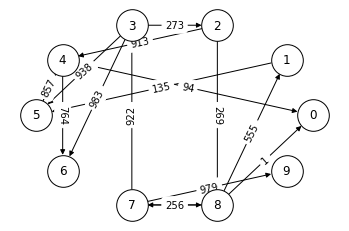

<Figure size 432x288 with 0 Axes>

In [18]:
"""Run TCDF"""
%matplotlib inline
%run -i "runTCDF.py" --data data/data_df.csv  --cuda --significance 0.99 --hidden_layers 2 --kernel_size 58 --log_interval 500 --epochs 1000 --plot

In [19]:
read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()

In [38]:
GC_set = np.zeros((10,10))
for i in list(read_dictionary.keys()):
    index1 = i
    for j in read_dictionary[i]:
        index2 = j
        GC_set[i][j] = 1

True variable usage = 40.00%
Estimated variable usage = 25.00%
Accuracy = 73.00%


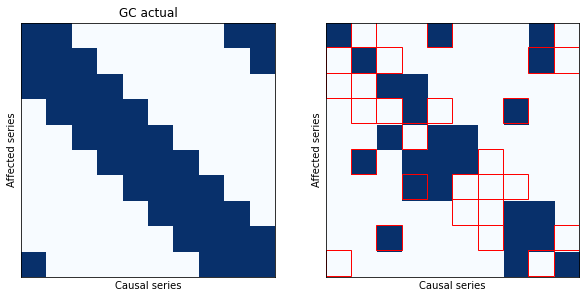

In [44]:
print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_set)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_set)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_set, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_set), len(GC_set), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_set)):
    for j in range(len(GC_set)):
        if GC[i, j] != GC_set[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()